In [1]:
!cat Dataset* > Dataset.zip

In [2]:
!unzip Dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Dataset/eosinophil/EO_581610.jpg  
  inflating: Dataset/eosinophil/EO_810213.jpg  
  inflating: Dataset/eosinophil/EO_801674.jpg  
  inflating: Dataset/eosinophil/EO_761108.jpg  
  inflating: Dataset/eosinophil/EO_106564.jpg  
  inflating: Dataset/eosinophil/EO_327928.jpg  
  inflating: Dataset/eosinophil/EO_119952.jpg  
  inflating: Dataset/eosinophil/EO_376623.jpg  
  inflating: Dataset/eosinophil/EO_769223.jpg  
  inflating: Dataset/eosinophil/EO_67379.jpg  
  inflating: Dataset/eosinophil/EO_330411.jpg  
  inflating: Dataset/eosinophil/EO_233502.jpg  
  inflating: Dataset/eosinophil/EO_874796.jpg  
  inflating: Dataset/eosinophil/EO_769690.jpg  
  inflating: Dataset/eosinophil/EO_16249708.jpg  
  inflating: Dataset/eosinophil/EO_565721.jpg  
  inflating: Dataset/eosinophil/EO_673984.jpg  
  inflating: Dataset/eosinophil/EO_731641.jpg  
  inflating: Dataset/eosinophil/EO_6091.jpg  
  inflating: Dataset/eosinophil/

In [3]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
CLASS_NUM = 5
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224, 3)
IMAGE_TRAIN = 'Dataset'

# prepare data
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training",
    seed=123,
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation",
    seed=123,
    shuffle=False
)

EPOCH_STEPS_TRAIN = int(8076/BATCH_SIZE)
EPOCH_STEPS_VAL = int(2017/BATCH_SIZE)

Found 8076 images belonging to 5 classes.
Found 2017 images belonging to 5 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50():
    X_input = Input((224, 224, 3))

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)


    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(CLASS_NUM,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [ ]:
model = ResNet50()

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
loss = CategoricalCrossentropy(
    name='categorical_crossentropy'
)
optimizer = SGD(learning_rate=0.0001)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
start = time.time()
train_history = model.fit(train_generator,
          steps_per_epoch=EPOCH_STEPS_TRAIN,
          epochs=100,
          validation_data=val_generator,
          validation_steps=EPOCH_STEPS_VAL,
          validation_freq=1)
end = time.time() - start
print("Processing time: {}".format(end))

Epoch 1/100
504/504 [==============================] - 184s 254ms/step - loss: 1.4302 - accuracy: 0.4333 - val_loss: 20.3999 - val_accuracy: 0.1870
Epoch 2/100
504/504 [==============================] - 124s 247ms/step - loss: 1.0605 - accuracy: 0.6108 - val_loss: 11.3678 - val_accuracy: 0.2257
Epoch 3/100
504/504 [==============================] - 125s 247ms/step - loss: 0.7282 - accuracy: 0.7465 - val_loss: 1.1078 - val_accuracy: 0.6186
Epoch 4/100
504/504 [==============================] - 125s 247ms/step - loss: 0.5270 - accuracy: 0.8177 - val_loss: 0.6089 - val_accuracy: 0.7827
Epoch 5/100
504/504 [==============================] - 125s 247ms/step - loss: 0.3899 - accuracy: 0.8705 - val_loss: 0.9776 - val_accuracy: 0.6751
Epoch 6/100
504/504 [==============================] - 124s 246ms/step - loss: 0.2896 - accuracy: 0.9059 - val_loss: 0.3325 - val_accuracy: 0.8988
Epoch 7/100
504/504 [==============================] - 126s 250ms/step - loss: 0.2378 - accuracy: 0.9223 - val_loss:

In [ ]:
model.save('ResNet50.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
history_all = {}
# Save history    
if len(history_all) == 0:
    history_all = {key: [] for key in train_history.history}

for key in history_all:
    history_all[key].extend(train_history.history[key])

In [ ]:
def show_train_history(history, xlabel, ylabel, train, title):
    for item in train:
        plt.plot(history[item])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

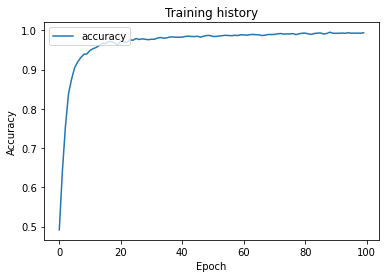

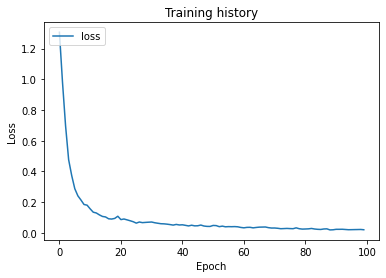

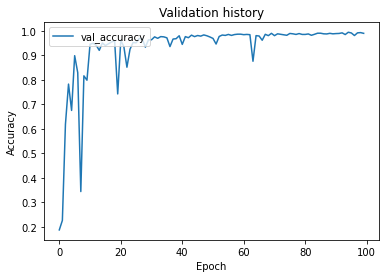

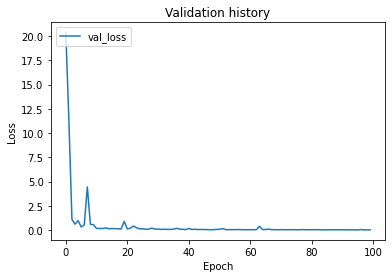

In [ ]:
show_train_history(history_all, 'Epoch', 'Accuracy', ('accuracy',), 'Training history')
show_train_history(history_all, 'Epoch', 'Loss', ('loss',), 'Training history')
show_train_history(history_all, 'Epoch', 'Accuracy', ('val_accuracy',), 'Validation history')
show_train_history(history_all, 'Epoch', 'Loss', ('val_loss',), 'Validation history')

In [ ]:
model = keras.models.load_model('ResNet50.h5')

In [ ]:
Y_pred = model.predict(val_generator)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
CLASS_NAMES= ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
print(classification_report(val_generator.classes, y_pred, target_names=CLASS_NAMES))

Confusion Matrix
[[241   0   0   0   0]
 [  1 605   0   1   1]
 [  1   0 232   4   0]
 [  0   0   3 274   0]
 [  2   1   0   9 642]]
Classification Report
              precision    recall  f1-score   support

    basophil       0.98      1.00      0.99       241
  eosinophil       1.00      1.00      1.00       608
  lymphocyte       0.99      0.98      0.98       237
    monocyte       0.95      0.99      0.97       277
  neutrophil       1.00      0.98      0.99       654

    accuracy                           0.99      2017
   macro avg       0.98      0.99      0.99      2017
weighted avg       0.99      0.99      0.99      2017



In [ ]:
from google.colab import files
files.download('ResNet50.h5')